# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import xarray as xr
import skill_metrics as sm;   import geopandas as gpd
import multiprocessing as mp
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from sklearn.neighbors import BallTree
from scipy.stats import linregress

source $HOME/miniforge3/bin/activate


### Defined Functions

In [2]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    '''
      :param begin: begin date of the data
    :param end: end date of the data
    :param station: noaa station id
    :param vdatum: vertical datum such as NAVD
    :param interval: interval of the data (6 minutes)
    :param form: format of the data (json)
    :param t_zone: time zone of the data (GMT)
    :param unit: unit of the data (metric)
    :param product: type of the data (water_level)
    '''
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [3]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/Raw_DATA')

ncfile = nc4.Dataset(root / '2019' /'outputs' / 'fort.63.nc','r')
lon = ncfile.variables['x'][:]
lat = ncfile.variables['y'][:]

In [4]:
gdf = gpd.read_file('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles/comm_and_flood/community+flood_wgs.shp')

In [5]:
gdf["centroid"] = gdf.geometry.centroid

# Extract lat/lon from centroid
obs_lat = gdf["centroid"].y.values
obs_lon = gdf["centroid"].x.values

# Find nearest model node
_, node_indices = point_lookup(lat, lon, obs_lat, obs_lon)
gdf["node_idx"] = node_indices[:, 0]

In [ ]:
years = ['2024']#,'2023','2022','2021','2020','2019',
         #'2018','2017','2016','2015','2014','2013',
         #'2012','2011','2010']

exceedance_all = []
for year in years:
    print(f"Processing year {year}...")
    ncfile = nc4.Dataset(root / year / "outputs" / "fort.63.nc")

    base_time = pd.to_datetime(ncfile.variables["time"].base_date)
    dt = pd.date_range(start=base_time, freq="1H", periods=ncfile.dimensions["time"].size)

    for idx, row in gdf.iterrows():
        node = row["node_idx"]
        flood_thresh = row["flood_MSL"]
        
        # Skip if flood threshold is missing
        if pd.isna(flood_thresh):
            continue

        name = row.get("CommunityN", f"Community_{idx}")
        community_id = row.get("CommunityI", f"ID_{idx}")

        wse = ncfile.variables["zeta"][:, node]
        df = pd.DataFrame({"dt": dt, "wse": wse})
        df_exceed = df[df["wse"] >= flood_thresh].copy()

        if not df_exceed.empty:
            df_exceed["Community"] = name
            df_exceed["CommunityID"] = community_id
            df_exceed["Flood_Stage"] = flood_thresh
            df_exceed["Year"] = int(year)
            exceedance_all.append(df_exceed)

# --- Step 3: Save Results ---
df_exceed_all = pd.concat(exceedance_all, ignore_index=True)
df_exceed_all.to_csv("/scratch/tmiesse/project/model_data/all_community_flood_exceedances.csv", index=False)

Processing year 2024...


In [4]:
stations = {'prudhoe':{'id':9497645,'lat':70.421459,'lon':-148.546311},
            'red':{'id':9491094,'lat':67.573681,'lon':-164.070663},
            'nome':{'id':9468756,'lat':64.499170,'lon':-165.431689},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}
resample_time = 'D'
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013',
        '2012','2011','2010']
name = 'prudhoe'

obs_lat = stations[name]['lat']
obs_lon = stations[name]['lon']
df_list,df_hourly_list = [],[]
for year in years:
    ncfile = nc4.Dataset(root / year /'outputs' / 'fort.63.nc')
    start = pd.to_datetime(ncfile.variables['time'].base_date)
    dt = pd.date_range(start=start,freq='1h',periods=ncfile.dimensions['time'].size)
    x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
    distances,node_ids = point_lookup(y, x,obs_lat,obs_lon)
    model = ncfile.variables['zeta'][:,node_ids[0][0]]
    df = pd.DataFrame({'dt': dt, 'data': model})
    df_daily_max = df.resample(resample_time, on='dt').max().reset_index()
    df_daily_max["Year"] = df_daily_max["dt"].dt.year
    df["Year"] = df["dt"].dt.year  # Add year column
    df_list.append(df_daily_max)
    df_hourly_list.append(df)

In [5]:
df_daily_wse = pd.concat(df_list, ignore_index=True)
df_daily_wse = df_daily_wse.iloc[1:].reset_index(drop=True)
df_annual_max = df_daily_wse.groupby("Year")["data"].max().reset_index()
slope_annual, intercept_annual, r_value, p_value, std_err = linregress(df_annual_max["Year"], df_annual_max["data"])
df_annual_max["Expected_WSE"] = df_annual_max["Year"] * slope_annual + intercept_annual
df_daily_wse["Year"] = df_daily_wse["dt"].dt.year
df_daily_wse["Month"] = df_daily_wse["dt"].dt.month
df_hourly_wse = pd.concat(df_hourly_list, ignore_index=True)
df_hourly_wse.to_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv')

In [4]:
# **Extract Metadata**
lats = ncfile.variables["y"][:]
lons = ncfile.variables["x"][:]
depths = ncfile.variables["depth"][:]

# **Filter Only Coastal Nodes (Depth Between -5m and 10m)**
coastal_mask = (depths > -15) & (depths <10)
coastal_nodes = np.where(coastal_mask)[0]

ncfile.close()



In [5]:
percentile_95_all_years = []  # Store 95th percentile across years
for year in range(2010, 2025):
    dataset = nc4.Dataset(root / str(year) / 'outputs' / 'fort.63.nc', 'r')
    dataset.set_auto_mask(False)  # ✅ Disable automatic masking for faster reads
    zeta_data = dataset.variables["zeta"][:]
    dataset.close()  # Close after loading
    percentile_95_all_years.append(np.percentile(zeta_data, 95, axis=0))  # Compute 95th percentile for this year
percentile_95_all_years = np.max(np.stack(percentile_95_all_years), axis=0)  # ✅ Compute highest 95th percentile across all years


In [ ]:
# **Create Geometry (Points)**
geometry = [Point(lon, lat) for lon, lat in zip(lons[coastal_nodes], lats[coastal_nodes])]

# **Create a GeoPandas GeoDataFrame**

gdf = gpd.GeoDataFrame({"Percentile95": percentile_95_all_years[coastal_nodes]}, geometry=geometry, crs="EPSG:4326")

gdf.to_file('/scratch/tmiesse/project/99_percentile_shp/percentile95.shp', driver="ESRI Shapefile")

_____________________________________

#### plot a map of the Hs at a specific time

In [8]:
shp_paths = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/arctic_shapefiles')
communities = gpd.read_file(shp_paths / 'communities' /'City_Boundaries_wgs84.shp')
county = gpd.read_file(shp_paths / 'Alaska_Borough_and_Census_Area_Boundaries' /'Alaska_Borough_and_Census_Area_Boundaries.shp')
coastline = gpd.read_file(shp_paths / 'Alaska_Coastline' /'Alaska_Coastline.shp')

In [9]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 58,71
lon1,lon2 = -172, -140

# defining the time range I want
#time1, time2 = np.datetime64('2024-10-11 21:00:00'),np.datetime64('2024-10-25 23:00:00')
# search for the nearest time to the time inputted
#idx = np.where((time1 < dt.values) &\
#               (dt.values < time2))[0]
ncfile = nc4.Dataset(root / '2017' /'outputs' / 'fort.63.nc','r')

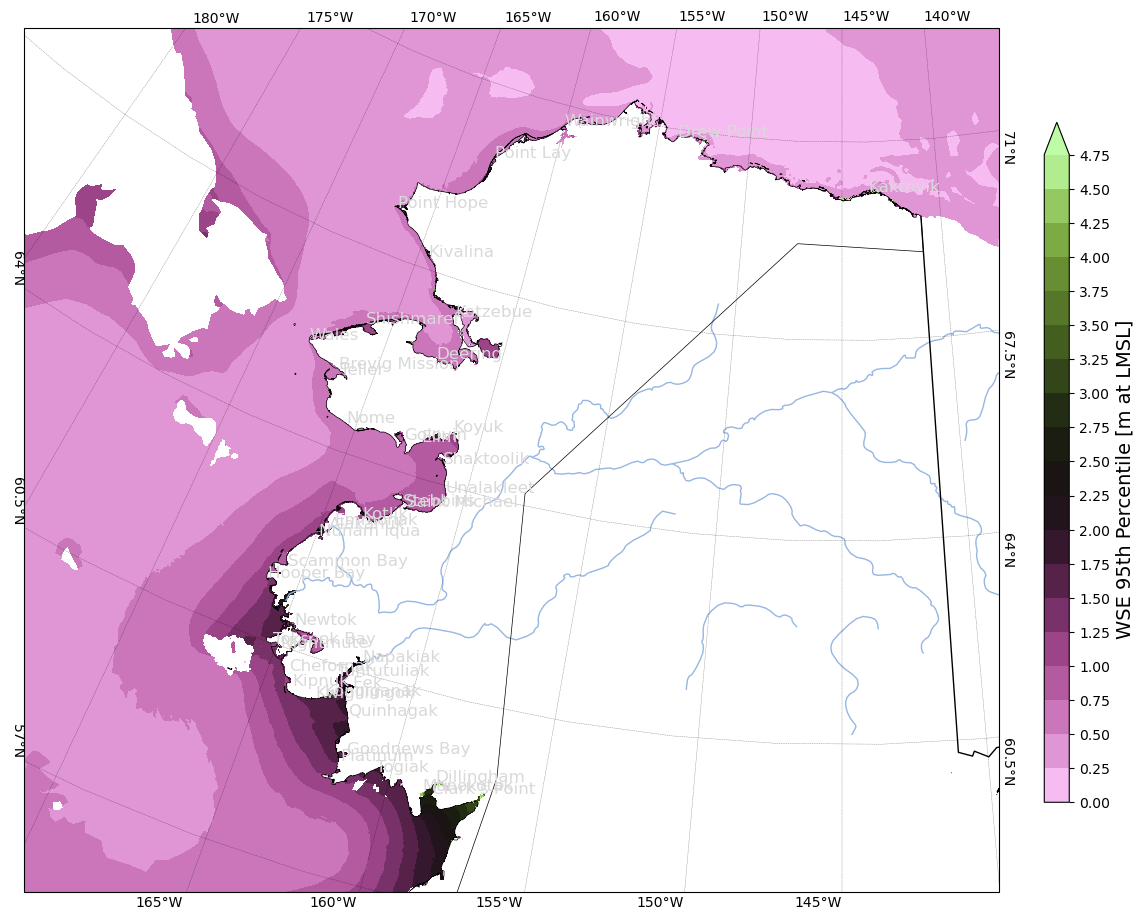

In [12]:
# plot parameters to initialize the plot
proj = ccrs.NorthPolarStereo(central_longitude=-145) # this data is in the arctic so we use the NorthPolarStereo projection
google_terrain = cimgt.GoogleTiles(style="satellite")
#proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))    
ax = plt.axes([0,0.,0.975,.975],projection=proj)
cmap = mpl.cm.get_cmap('vanimo')

# define countorus levels and colormap
levels = np.arange(0.,5.,0.25)


# plot the model data on a map
# this is a triangular grid so we need to define the triangles
# and we need to use tricontourf to plot the data
triang = tri.Triangulation(lons,lats, triangles=ncfile.variables['element'][:,:]-1)
#Z = np.max(ncfile['zeta'][idx,:],axis=0)
#if Z.mask.any():
#    point_mask_indices = np.where(Z.mask)
#    tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , \
#                              point_mask_indices).reshape(-1, 3), axis=1)
#    triang.set_mask(tri_mask)
cf = ax.tricontourf(triang, percentile_95_all_years,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)


for c in range(len(communities)):
    cx,cy = communities.iloc[c].geometry.centroid.x,communities.iloc[c].geometry.centroid.y
    cname = communities.iloc[c]['CommunityN']
    if shapely.vectorized.contains(Polygon([(lon1,lat1),(lon1,lat2),(lon2,lat2),(lon2,lat1)]),cx,cy)==True:
        ax.text(cx,cy,cname,fontsize=12,transform=ccrs.PlateCarree(),color='#d9d9d9')
for c in range(len(coastline)):
    cx,cy = coastline.iloc[c].geometry.exterior.xy
    ax.plot(cx,cy,transform=ccrs.PlateCarree(),color='black',linewidth=0.5)
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
#ax.add_image(google_terrain, 8)
#ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.RIVERS,linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
gl = ax.gridlines(xlocs=np.arange(-190,-100,5),ylocs=np.arange(-90,90,3.5),
                            draw_labels=True,linewidth=0.3, color="black", alpha=0.5,
                            y_inline=False,linestyle="--",zorder=20)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.xlabel_style = {'rotation': 0}
gl.ylabels_left = False
gl.ylabels_right= True
gl.ylabel_style = {'rotation': -90}
gl.ypadding = 1.25
gl.xformatter = cart.mpl.gridliner.LONGITUDE_FORMATTER
gl.xpadding = 8

# add the colorbar
cbar_ax = fig.add_axes([1.02,.145,0.025,0.68])
cbar = fig.colorbar(cf,cax = cbar_ax, ticks=levels,orientation='vertical')
cbar.set_label(label = r'WSE 95th Percentile [m at LMSL]',fontsize =14)
#cbar_ax2 = fig.add_axes([0.,-0.075,0.97,0.02])
#cbar = mpl.colorbar.ColorbarBase(cbar_ax2, cmap=mpl.cm.get_cmap('gist_gray'), values=ice_level2,
#                                    ticks=ice_level1,orientation='horizontal')

#cbar.set_label(label = r'Sea Ice Concentration [0-1]',fontsize =12,labelpad=-0.1)

plt.show()

In [ ]:
def fmt(x):
    s = f"{x:.1f}"
    s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
def omitcontours(cf):
    for level in cf.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!
            # include test for "smallness" of your choice here:
            # I'm using a simple estimation for the diameter based on the
            #    x and y diameter...
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
            if diameter<2: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(
    return

In [ ]:
shapely.vectorized.contains(Polygon([(lon1,lat1),(lon1,lat2),(lon2,lat2),(lon2,lat2)]),cx,cy)#==True